In [1]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, correlate, find_peaks, hilbert
from scipy import signal
import scipy.signal as sp
import sigmf
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.units import Quantity
import astropy.constants
from astropy.time import Time
from scipy.signal import correlate, correlation_lags, find_peaks, hilbert
import pywt
from scipy.signal import lfilter

In [2]:
sample_rate = 2000
duration = 280
number_of_samples = int(duration * sample_rate)
fs = sample_rate
osr = 1
chirp_bw = 1000
chirp_rate = 1

In [3]:
# noise
rng = np.random.default_rng()
noise = np.random.standard_normal(number_of_samples) + 1j*np.random.standard_normal(number_of_samples)
signal = np.repeat(1,number_of_samples)

In [4]:
phase_noise_std = .005  # Adjust for more/less phase noise
wn = np.random.randn(int(number_of_samples)) * phase_noise_std  # White noise
b = [1.0]  # FIR filter (no filtering)
a = [1.0, -0.999]  # IIR filter (smooths phase variations)
doppler_variation = lfilter(b, a, wn)  # Filtered noise
doppler_phase = 2 * np.pi * np.cumsum(doppler_variation) / fs

In [5]:
def chirp(fs_Hz, rep_Hz, f0_Hz, f1_Hz, periods=1, phase_rad=0):

    T_s = 1 / rep_Hz # Period of chirp in seconds.
    c = (f1_Hz - f0_Hz) / T_s # Chirp rate in Hz/s.
    n = int(fs_Hz / rep_Hz) # Samples per repetition.
    t_s = np.linspace(0, T_s, n) # Chirp sample times.

    # Phase, phi_Hz, is integral of frequency, f(t) = ct + f0.
    phi_Hz = (c * t_s**2) / 2 + (f0_Hz * t_s) # Instantaneous phase.
    phi_rad = 2 * np.pi * phi_Hz # Convert to radians.
    phi_rad += phase_rad # Offset by user-specified initial phase.
    return np.tile(np.exp(1j * phi_rad), periods) # Complex I/Q.

In [6]:
signal = chirp(float(fs), chirp_rate, -chirp_bw/2, chirp_bw/2, int(chirp_rate*duration), 0.0)
signal.shape

(560000,)

In [7]:
# T = 1/chirp_rate
# t = np.linspace(0, T, int(fs * T), endpoint=False)
# chan_freq = chirp_bw * np.sin(np.pi * t / T)**2
# chan_chirp = np.exp(1j * 2 * np.pi * np.cumsum(chan_freq) / fs) 
# signal = np.tile(chan_chirp,duration)
# signal.shape

In [8]:
# signal = np.roll(signal,int(fs/8))

In [9]:
freq_offset = 12 # Hz
signal = signal*np.exp(-1j * 2 * np.pi * (-freq_offset / fs) * np.arange(len(signal)))

In [10]:
# signal = signal * np.exp(1j * doppler_phase)  # Phase broadened signal

In [11]:
fdrift = -0.00;
new_sig = np.zeros(len(signal), dtype=np.complex64 );
f = 0;
phi = 0;
for k in range(0, len(signal) ):
    new_sig[k] = signal[k] * np.exp(1j*2*np.pi*phi);
    f = f + fdrift*1/fs;
    phi = phi + f/fs;
signal = new_sig;

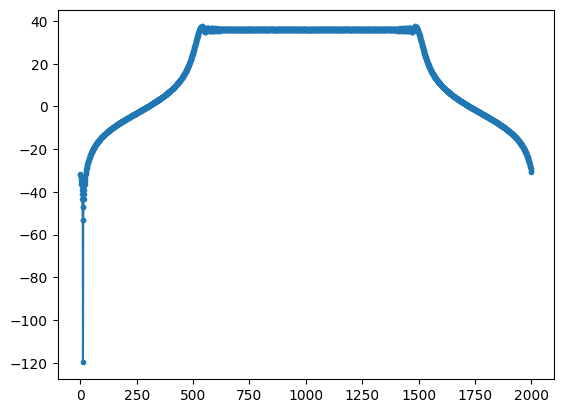

In [12]:
spectrum_tx = np.abs(np.fft.fftshift(np.fft.fft(signal.reshape(-1, int(sample_rate)))))
spectrum_tx = spectrum_tx**2
ig, ax = plt.subplots()
ax.plot(10*np.log10(
    (
    np.mean(
    np.abs(
        spectrum_tx
    ), axis=0
    ))
), '.-');

In [13]:
SNR_dB = -5 # in 1 Hz
SNR_dB -= 10*np.log10(sample_rate)
sigma2 = (10**(-SNR_dB/10))*osr;
# sigma2

In [14]:
noise_scaled = np.sqrt(sigma2/2)*noise;
total = noise_scaled + signal

total_power = np.mean(np.abs(total)**2)
noise_scaled_power = np.mean(np.abs(noise_scaled)**2)
signal_power = np.mean(np.abs(signal)**2)

In [15]:
# in 2500 Hz fofr WSJT-X comparison
10*np.log10(signal_power)-10*np.log10(noise_scaled_power)+10*np.log10(sample_rate/2500)

-38.98515778473327

In [16]:
spectrum_on = np.abs(np.fft.fftshift(np.fft.fft(total.reshape(-1, int(sample_rate)))))
spectrum_on.shape

(280, 2000)

In [17]:
spectrum_on_pow = spectrum_on**2

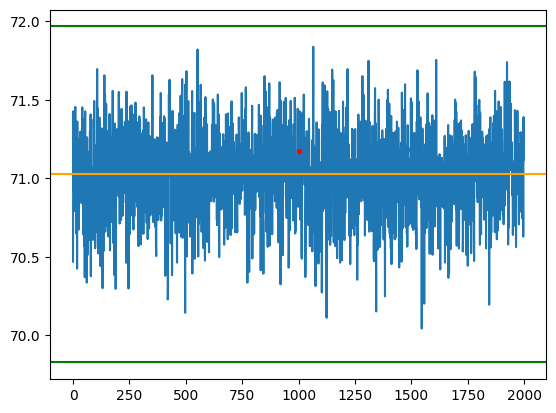

In [18]:
ig, ax = plt.subplots()
ax.plot(10*np.log10(
    (
    np.mean(
    np.abs(
        spectrum_on_pow
    ), axis=0
    ))
), '-', label="on")

ax.plot(int(sample_rate/2),10*np.log10(
    np.mean(
    np.abs(
        spectrum_on_pow
    ), axis=0
    )[int(sample_rate/2)]
), '.', color="red")

ax.axhline((10*np.log10(np.mean((spectrum_on_pow)))), color="orange");
ax.axhline(10*np.log10(np.mean(spectrum_on_pow)+
                       4*np.std( np.mean(
    np.abs(
        spectrum_on_pow
    ), axis=0
    )
)), color="green");

ax.axhline(10*np.log10(np.mean(spectrum_on_pow)-
                       4*np.std( np.mean(
    np.abs(
        spectrum_on_pow
    ), axis=0
    )
)), color="green");
# ax.set_xlim(1200,1300)

In [19]:
overlap = 4
wola_size = sample_rate*overlap
wola_buffer = np.zeros(wola_size)+0*1j
blocks = len(total)//(sample_rate)
blocks

280

In [20]:
# Blackman-Harris

a0 = 0.35875;
a1 = 0.48829;
a2 = 0.14128;
a3 = 0.01168;

taps = np.zeros(wola_size)
blackman_window = np.zeros(wola_size)
for i in range(wola_size):
    j = i - (wola_size)/2;
    x = (overlap*np.pi)*(j/(wola_size/1));
    if (x!=0):
        taps[i] = np.sin(x)/(x)
    else:
        taps[i] = 1
    blackman_window[i] = a0 - a1*np.cos(2*np.pi*i/(wola_size-1))+ a2*np.cos(4*np.pi*i/(wola_size-1)) + a3*np.cos(6*np.pi*i/(wola_size-1));
#     blackman_window[i] = blackman_window[i]*taps[i]

In [21]:
total_fft = np.zeros(sample_rate)

for i in range(0,blocks):
    wola_buffer[:(overlap-1)*sample_rate] = wola_buffer[sample_rate:]
    wola_buffer[(overlap-1)*sample_rate:] = total[i*sample_rate:(i+1)*sample_rate]
    fft_input = np.mean( ((wola_buffer*blackman_window).reshape(overlap,-1)), axis=0)
    correlation_fft = np.fft.fft(fft_input)
    
    total_fft += np.abs(correlation_fft)

fft_result = np.abs(np.fft.fftshift(total_fft)) ** 2 

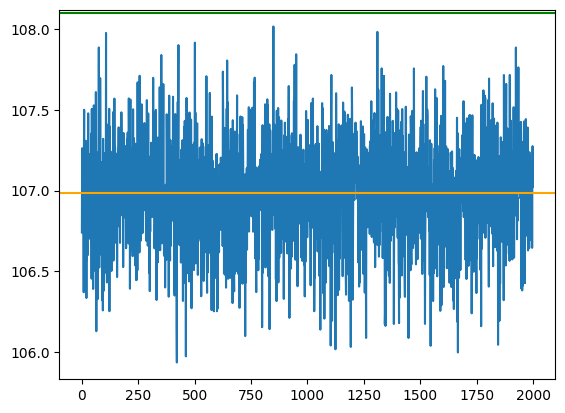

In [22]:
ig, ax = plt.subplots()
ax.plot(10*np.log10(
    fft_result
), '-', label="on")

ax.axhline((10*np.log10(np.mean((fft_result)))), color="orange");
ax.axhline(10*np.log10(np.mean(fft_result)+
                       4*np.std( 
    fft_result
)), color="green");


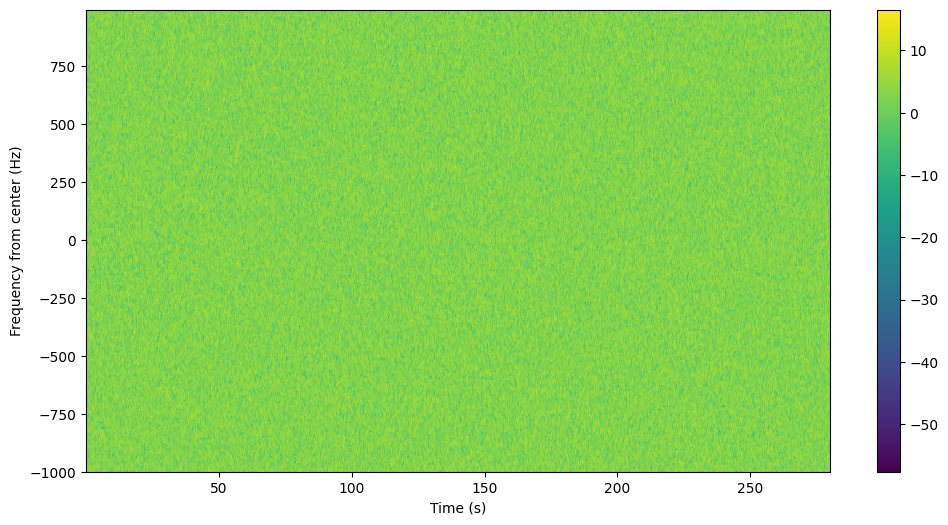

In [23]:
fig, ax0 = plt.subplots(figsize=(12, 6))
pxx, freq, t, cax = ax0.specgram(total, Fs=fs) # , clim=[-40, -20] NFFT=int(fs/10)
# ax0.set_ylim([-30e3, 30e3])
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Frequency from center (Hz)")
fig.colorbar(cax);

In [24]:
single_chirp = chirp(float(fs), chirp_rate, -chirp_bw/2, chirp_bw/2, 1, 0)

In [25]:
# single_chirp = single_chirp * np.exp(1j * doppler_phase[:len(single_chirp)])

In [26]:
# T = 1/chirp_rate
# t = np.linspace(0, T, int(fs * T), endpoint=False)
# chan_freq = chirp_bw * np.sin(np.pi * t / T)**2
# chan_chirp = np.exp(1j * 2 * np.pi * np.cumsum(chan_freq) / fs) 
# single_chirp = chan_chirp

In [27]:
# FFT correlation
chirp_padded = np.pad(single_chirp, (0, len(signal) - len(single_chirp)), mode='constant')
chirp_padded.shape

(560000,)

In [28]:
correlation_fft = np.fft.fft(total) * np.conj(np.fft.fft(chirp_padded))

In [29]:
cor = (np.fft.ifft(correlation_fft))
cor = np.abs(cor) ** 2 

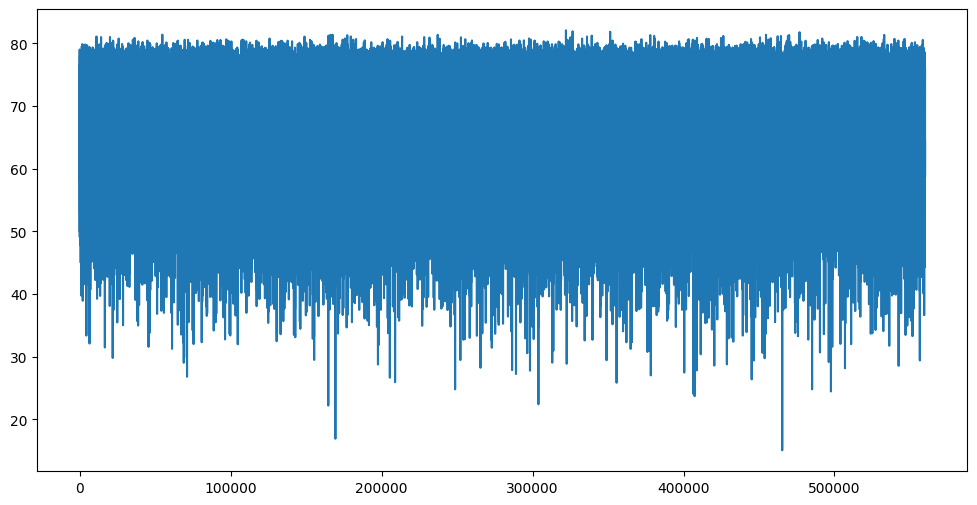

In [30]:
fig, ax0 = plt.subplots(figsize=(12, 6))
ax0.plot( 10 * np.log10(abs(cor)), label="signal");

In [31]:
folded_corr = np.mean( np.abs(cor[0:number_of_samples]).reshape(int(duration*chirp_rate),-1), axis=0)

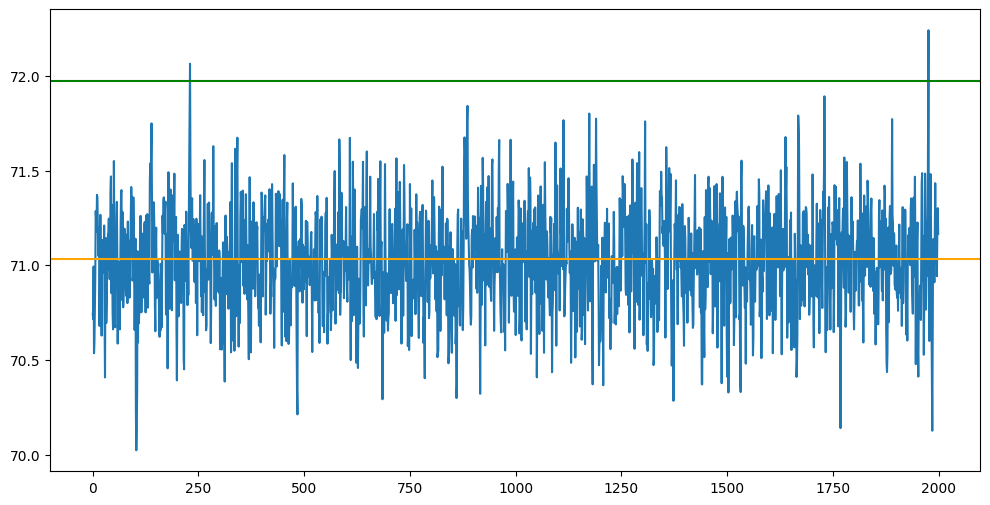

In [32]:
fig, ax0 = plt.subplots(figsize=(12, 6))
ax0.plot(10*np.log10(np.abs(folded_corr)), label="signal");
ax0.axhline(10*np.log10(np.mean(np.abs(folded_corr))+4*np.mean(np.std(folded_corr))), color="green");
ax0.axhline(10*np.log10(np.mean(np.abs(folded_corr))), color="orange");

In [33]:
10*np.log10(np.max(np.abs(folded_corr)))-10*np.log10(np.mean(np.abs(folded_corr))+4* np.mean(np.std(folded_corr))   )

0.26733046543105843

In [34]:
overlap = 4
wola_size = sample_rate*overlap
wola_buffer = np.zeros(wola_size)+0*1j
blocks = len(total)//(sample_rate)
blocks

280

In [35]:
# Blackman-Harris

a0 = 0.35875;
a1 = 0.48829;
a2 = 0.14128;
a3 = 0.01168;


taps = np.zeros(wola_size)
blackman_window = np.zeros(wola_size)
for i in range(wola_size):
    j = i - (wola_size)/2;
    x = (overlap*np.pi)*(j/wola_size);
    if (x!=0):
        taps[i] = np.sin(x)/(x)
    else:
        taps[i] = 1
    blackman_window[i] = a0 - a1*np.cos(2*np.pi*i/(wola_size-1))+ a2*np.cos(4*np.pi*i/(wola_size-1)) + a3*np.cos(6*np.pi*i/(wola_size-1));
#     blackman_window[i] = blackman_window[i]*taps[i]


In [36]:
chirp_padded = np.pad(single_chirp, (0, len(wola_buffer) - len(single_chirp)), mode='constant')
chirp_padded.shape

(8000,)

In [37]:
total_cor = np.zeros(sample_rate)

for i in range(0,blocks):
    wola_buffer[:(overlap-1)*sample_rate] = wola_buffer[sample_rate:]
    wola_buffer[(overlap-1)*sample_rate:] = total[i*sample_rate:(i+1)*sample_rate]
    fft_input = np.mean( ((wola_buffer*blackman_window).reshape(overlap,-1)), axis=0)
    correlation_fft = np.fft.fft(fft_input) * np.conj(np.fft.fft(single_chirp))
    
    total_cor += np.abs(np.fft.ifft(correlation_fft))

cor = np.abs(total_cor) ** 2 

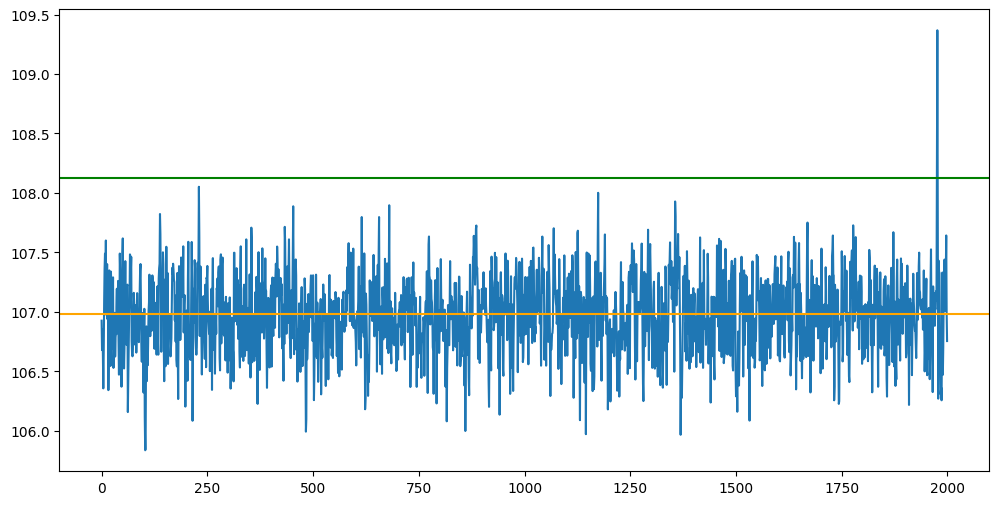

In [38]:
fig, ax0 = plt.subplots(figsize=(12, 6))
ax0.plot( 10 * np.log10(abs(cor)), label="signal");
ax0.axhline(10*np.log10(np.mean(np.abs(cor))+4* np.mean(np.std(cor))), color="green");
ax0.axhline(10*np.log10(np.mean(np.abs(cor))), color="orange");

In [39]:
10*np.log10(np.max(np.abs(cor)))-10*np.log10(np.mean(np.abs(cor))+4* np.mean(np.std(cor)))

1.2400254921872431